In [1]:
import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
from My_Jampy import JAM                          #My class for jampy


data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens_tests/autolens_workspace/Test_3/Simulation_data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("JAM_Input.txt", unpack=True)      #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("SDP81_pseudo-DM.txt", unpack=True)     #DM component
norm_psf, sigma_psf           = np.loadtxt("MUSE_Psf_model.txt", unpack=True) #PSF
xbin, ybin, vrms              = np.loadtxt("vrms_data.txt", unpack=True)          #Vrms data


In [3]:
#In order: ML, beta, inc, log_mbh, log_rho_s, qDM, mag_shear, phi_shear, gamma
p0 = np.array([7.77, -0.55, 77, 9, 8.69, 1, 0.05, 88, 1.0])

In [4]:
#Only for lensing modelling 
z_lens    = 0.299                                                         #Lens Redshift
z_source    = 3.100                                                         #Source Redshift 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
dm_int = 0.05 * (10**10)                                               #Intensity of DM (~ 20% of lum_mass)
ml     = 7.7                                                           #mass to light ratio
beta   = np.ones_like(surf_lum)*-0.55
inc    = 77
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear

pixsize = 0.2    #MUSE pixel size

#Angular diameter distances
D_l = cosmo.angular_diameter_distance(z_lens)                   #Lens              
D_s = cosmo.angular_diameter_distance(z_source)                 #Source
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)   #Lens to source

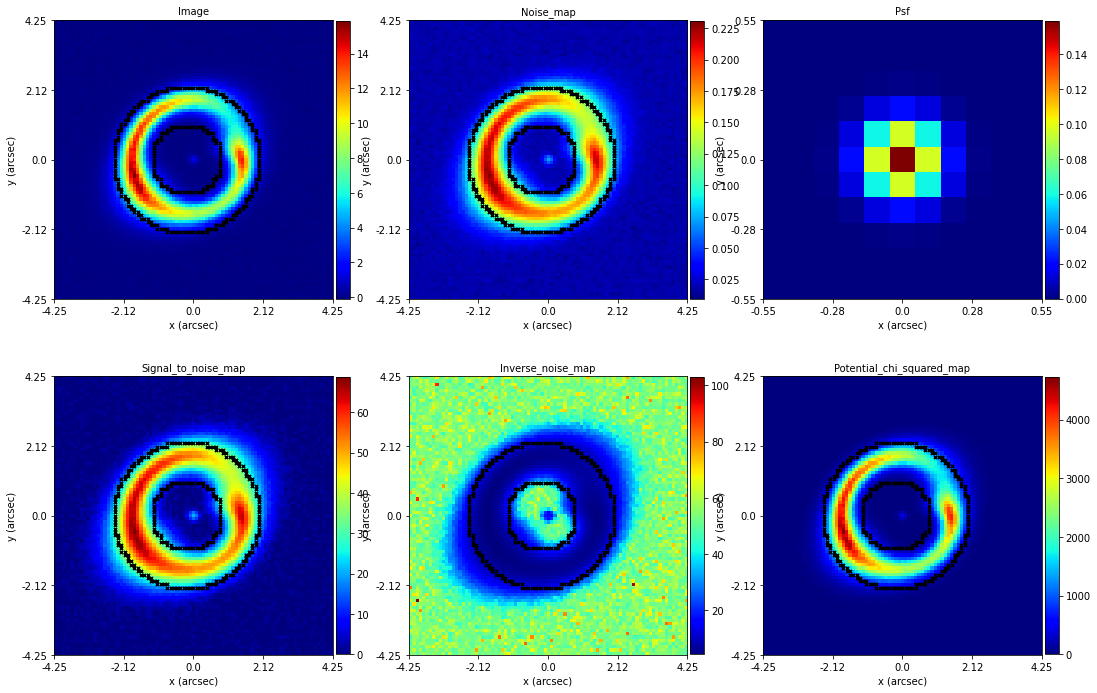

In [5]:
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/arcs_simulation.fits",
        noise_map_path=f"{data_folder}/noise_simulation.fits",
        psf_path=f"{data_folder}/psf_simulation.fits",
        pixel_scales=0.1,
    )

mask = al.Mask.circular_annular(centre=(0.0, -0.2), inner_radius=1., outer_radius=2.3,
                              pixel_scales=imaging.pixel_scales, shape_2d=imaging.shape_2d) #Create a mask

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)     #Masked image


aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=False),                         #Plot
)

In [6]:
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()


#Components
mass_profile.MGE_comps(z_l=z_lens, z_s=z_source,
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm =dm_int * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm,)

#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_lens,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [7]:
#Now we set the tracer to the source galaxy

start = clock()

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_source)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_image.grid)[1]

print("Elapsed time", clock() - start)

Elapsed time 4.010786932999963


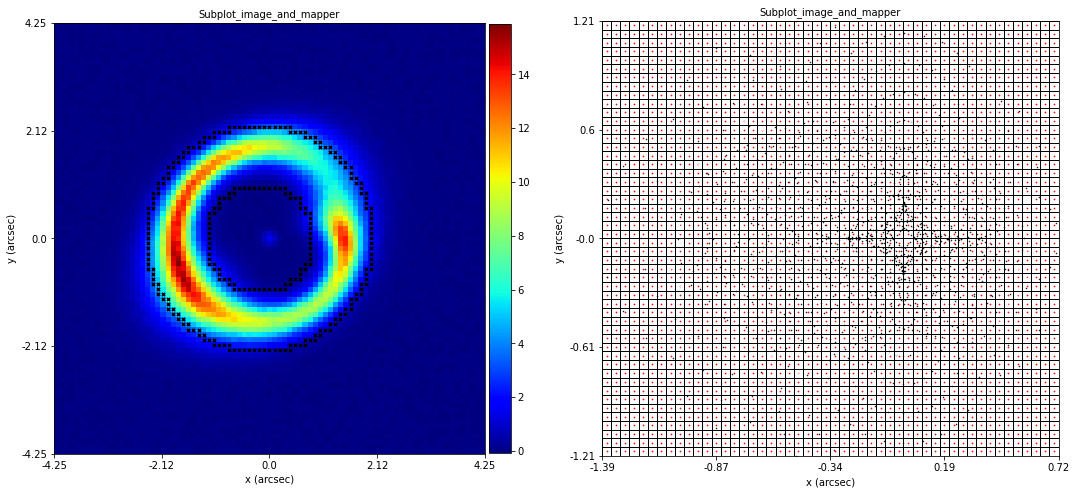

In [8]:
rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

Elapsed time 0.7580532509996374


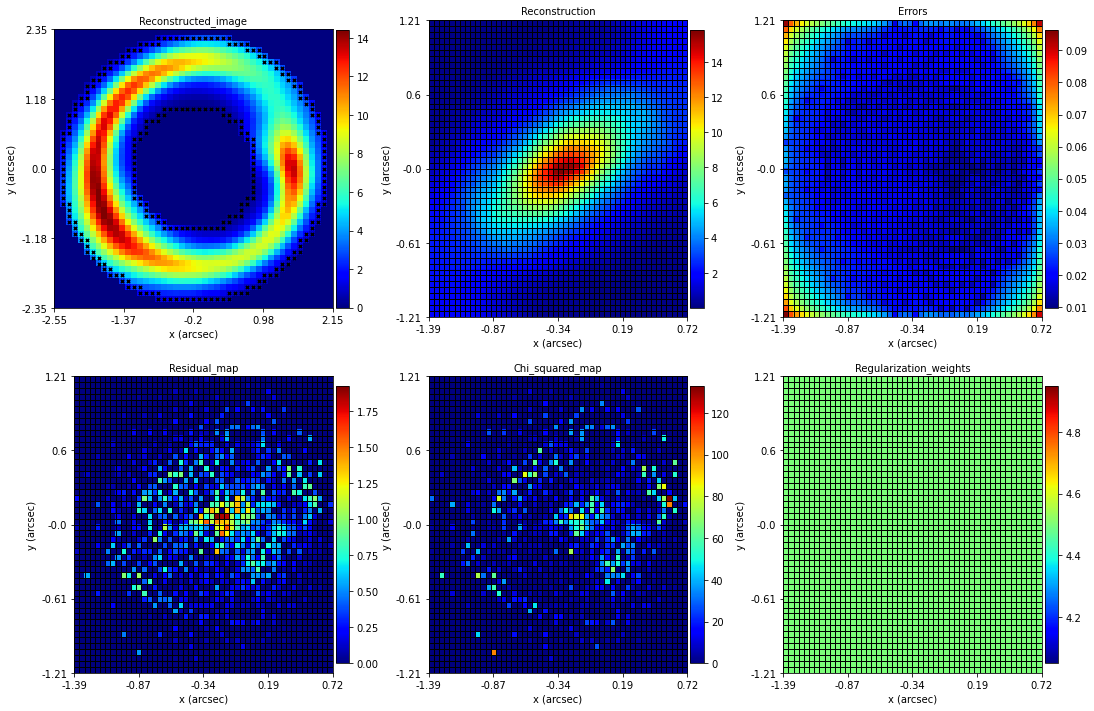

In [9]:
start = clock()
inversion = al.Inversion(
    masked_dataset=masked_image,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=4.5),
)
print("Elapsed time", clock() - start)

aplt.Inversion.subplot_inversion(inversion, include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False))

In [10]:
inversion.chi_squared_map.sum()

12275.864951077108

In [11]:
# JAMPY MODEL

Jam_model = JAM(ybin=ybin, xbin=xbin, inc=inc, distance=D_l.value, mbh=mbh, beta=beta, rms=vrms,
               normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

    #Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                qobs_lum=qobs_lum, ml=ml)
    #Add DM component
Jam_model.DM_component(surf_dm=dm_int * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: divide by zero encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')
/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: invalid value encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')


jam_axi_rms elapsed time sec: 0.77
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.987
Total mass MGE: 6.825e+11
296.1304933047629


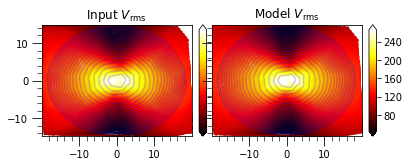

In [12]:
RMSMODEL, ML_model,CHI2,Tchi2 = Jam_model.run(quiet=False, plot=True)
print(Tchi2)

In [13]:
def log_likelihood(pos):
    ml_m, beta_m, inc_m, log_mbh_m , log_rho_s_m, qdm_m, mag_shear_m, phi_shear_m, gamma_m = pos._value
    
    ml_m   = (ml_m._value)
    beta_m = beta_m._value
    inc_m  = inc_m._value
    log_mbh_m = log_mbh_m._value
    log_rho_s_m = log_rho_s_m._value
    qdm_m = qdm_m._value
    mag_shear_m = mag_shear_m._value
    phi_shear_m = phi_shear_m._value
    gamma_m = gamma_m._value

    
    mass_profile.MGE_comps(z_l=z_lens, z_s=z_source, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml_m,
                       mbh=10**log_mbh_m, surf_dm =10**log_rho_s_m * surf_dm, sigma_dm=sigma_dm, qobs_dm=np.ones_like(surf_dm)*qdm_m)
    
    shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear_m, phi=phi_shear_m) #external shear

    lens_galaxy = al.Galaxy(
    redshift=z_lens,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
    )
    
    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_source)])
    source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_image.grid)[1]
    
    rectangular = al.pix.Rectangular(shape=(50, 50))
    mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)
    
    inversion = al.Inversion(
    masked_dataset=masked_image,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=4.5),
    )
    
    Jam_model = JAM(ybin=ybin, xbin=xbin, inc=inc_m, distance=D_l.value, mbh=10**log_mbh_m, beta=np.ones_like(surf_lum)*beta_m, rms=vrms,
               normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

    #Add Luminosity component
    Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                qobs_lum=qobs_lum, ml=ml_m)
    #Add DM component
    Jam_model.DM_component(surf_dm=10**log_rho_s_m * surf_dm, sigma_dm=sigma_dm, qobs_dm=np.ones_like(surf_dm)*qdm_m)
    
    RMSMODEL, ML_model,CHI2,Tchi2 = Jam_model.run(quiet=True, plot=False)
    print(inversion.chi_squared_map.sum(), Tchi2)
    return 0.5 * (inversion.chi_squared_map.sum() + Tchi2)
    

In [61]:
def log_likelihood2(ml_m, beta_m, inc_m, log_mbh_m , log_rho_s_m, qdm_m, mag_shear_m, phi_shear_m, gamma_m):
    print(ml_m, beta_m)
    mass_profile.MGE_comps(z_l=z_lens, z_s=z_source, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml_m,
                       mbh=10**log_mbh_m, surf_dm =10**log_rho_s_m * surf_dm, sigma_dm=sigma_dm, qobs_dm=np.ones_like(surf_dm)*qdm_m)
    
    shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear_m, phi=phi_shear_m) #external shear

    lens_galaxy = al.Galaxy(
    redshift=z_lens,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
    )
    
    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_source)])
    source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_image.grid)[1]
    
    rectangular = al.pix.Rectangular(shape=(50, 50))
    mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)
    
    inversion = al.Inversion(
    masked_dataset=masked_image,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=4.5),
    )
    
    Jam_model = JAM(ybin=ybin, xbin=xbin, inc=inc_m, distance=D_l.value, mbh=10**log_mbh_m, beta=np.ones_like(surf_lum)*beta_m, rms=vrms,
               normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

    #Add Luminosity component
    Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                qobs_lum=qobs_lum, ml=ml_m)
    #Add DM component
    Jam_model.DM_component(surf_dm=10**log_rho_s_m * surf_dm, sigma_dm=sigma_dm, qobs_dm=np.ones_like(surf_dm)*qdm_m)
    
    RMSMODEL, ML_model,CHI2,Tchi2 = Jam_model.run(quiet=True, plot=False)
    print(inversion.chi_squared_map.sum(), Tchi2)
    return 0.5 * (inversion.chi_squared_map.sum() + Tchi2)
    

In [163]:
def log_likelihood3(pos):
    ml_m, beta_m, inc_m, log_mbh_m , log_rho_s_m, mag_shear_m, phi_shear_m, gamma_m = pos
    #print(pos)
    qdm_m = 9.64068118e-01,
    mass_profile.MGE_Updt_parameters(ml=ml_m, mbh=10**log_mbh_m, gamma=gamma_m, 
                                                surf_dm=10**log_rho_s_m * surf_dm, qobs_dm=np.ones_like(surf_dm)*qdm_m)
    
    
    shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear_m, phi=phi_shear_m) #external shear

    lens_galaxy = al.Galaxy(
    redshift=z_lens,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
    )
    
    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_source)])
    source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_image.grid)[1]
    
    rectangular = al.pix.Rectangular(shape=(50, 50))
    mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)
    
    inversion = al.Inversion(
    masked_dataset=masked_image,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=4.5),
    )
    #aplt.Inversion.subplot_inversion(inversion)
    
    Jam_model = JAM(ybin=ybin, xbin=xbin, inc=inc_m, distance=D_l.value, mbh=10**log_mbh_m, beta=np.ones_like(surf_lum)*beta_m, rms=vrms,
               normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

    #Add Luminosity component
    Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                qobs_lum=qobs_lum, ml=ml_m)
    #Add DM component
    Jam_model.DM_component(surf_dm=10**log_rho_s_m * surf_dm, sigma_dm=sigma_dm, qobs_dm=np.ones_like(surf_dm)*qdm_m)
    
    RMSMODEL, ML_model,CHI2,Tchi2 = Jam_model.run(quiet=True, plot=False)
    #print(inversion.chi_squared_map.sum(), Tchi2)
    return 0.5 * (inversion.chi_squared_map.sum() + Tchi2)
    

In [14]:
import numdifftools as nd

In [56]:
#In order: ML, beta, inc, log_mbh, log_rho_s, qDM, mag_shear, phi_shear, gamma
p0 = np.array([7.77, -0.55, 77, 9, 8.69, 0.05, 88, 1.0])
p1 = np.array([ 7.77e+00, -5.50e-01,  7.70e+01,  9.00e+00,  8.69e+00, -1.00e+00,  5.00e-02,
  8.80e+01,  1.00e+00])

[ 7.77e+00 -5.50e-01  7.70e+01  9.00e+00  8.69e+00  5.00e-02  8.80e+01
  1.00e+00]


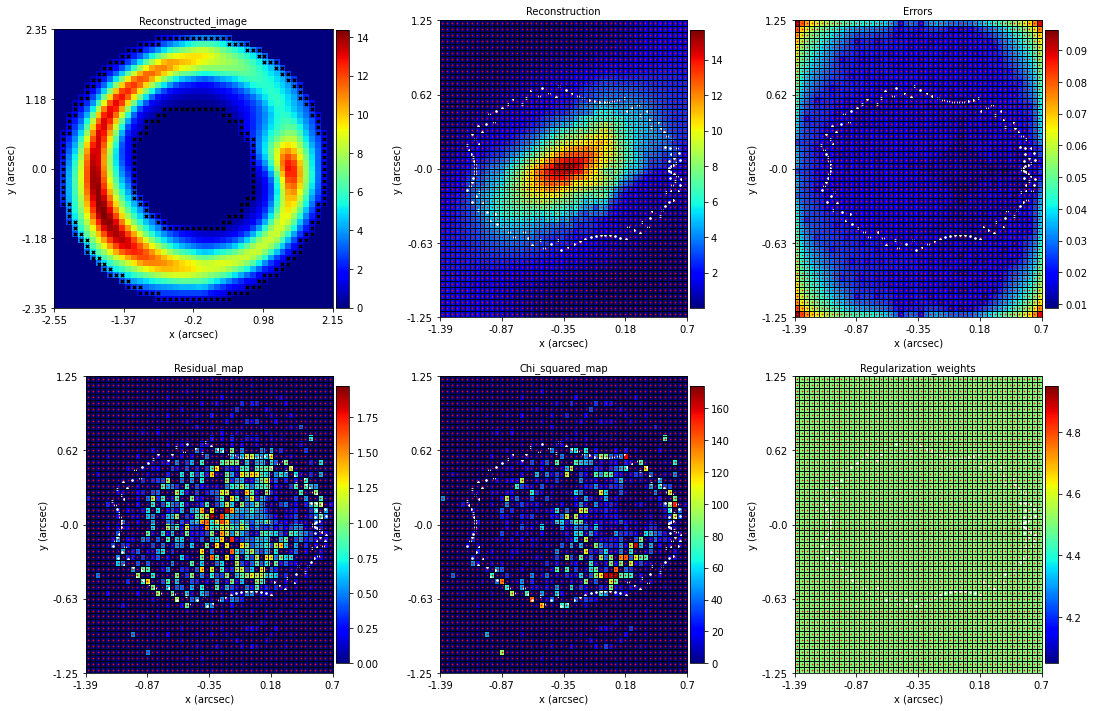

19715.545680181294 256.02988962355926


9985.787784902426

In [57]:
log_likelihood3(p0)

__Using Fisher information__

In [59]:
grad_resul = nd.Gradient(log_likelihood3)
grad_resul(p0)

19715.545680181294 256.02988962355926
30635.224767000618 8328.840453610359
25951.859921566087 15884.564069999076
19715.545680181294 98785.90725680084
19715.545680181294 2929.383389716326
19715.545680181294 253.84433533074844
19715.545680181294 360.37716688735975
22957.945574633937 7959098.141666012
18803.57319480732 269.3715802183865
43978.54629614952 12086984.982653106
19331.732635194086 272.2248897933514
32988.74213350851 256.02988962355926
38815.53232584844 256.02988962355926
21909.895396322812 256.02988962355926
17699.88823893793 256.02988962355926
15690.99869643631 256.02988962355926
23385.774188418312 256.02988962355926


KeyboardInterrupt: 

In [60]:
hess_ = nd.Hessian(log_likelihood3)
hess_result = hess_(p0)

19715.545680181294 256.02988962355926
16155.954383509807 27623.166891451867
26427.116218287294 137835.71746993583
30635.224767000618 224773.39350222424
30635.224767000618 23295.898492434593
25951.859921566087 14052.06922912517
25951.859921566087 9207.484844068527
30635.224767000618 9166.336865038233
30635.224767000618 6593.946610649267
25951.859921566087 15207.508917413745
25951.859921566087 17256.93160957186
23262.153464545467 8179375.2456795825
31621.645515150565 8296.54821039303
22643.857078662793 7889224.436591697
26464.233844513146 15989.10995306136
46212.382346385566 12153538.254934575
30879.507640091673 8201.411557545827
41859.924346113745 12021652.869953044
25841.181819946083 16092.66669706304
39772.513249424126 8328.840453610359
80302.34662708823 8328.840453610359
32036.071960480265 15884.564069999076
34899.26314355378 15884.564069999076
18826.877823329305 8328.840453610359
23537.33706121086 8328.840453610359
25650.418901959427 15884.564069999076
26506.499554699578 15884.56406

45484.38367640271 44373.971397246074
17570.014753118412 278.0567147009373
23737.61981090833 278.0567147009373
38246.57960159729 188523611.54588485
19331.732635194086 297.4874222538281
49830.302982567715 88581.84932954519
88490.24811550672 88581.84932954519
76886.5267861923 303.51615962404196
99050.0919845061 303.51615962404196
74139.69437728054 88581.84932954519
74186.99098695716 88581.84932954519
21266.78817453759 303.51615962404196
17543.149992296276 303.51615962404196
20304.353367851123 88581.84932954519
26608.25902769906 88581.84932954519
17582.223291742062 303.51615962404196
24077.74129246871 303.51615962404196
31431.098942097633 256.02988962355926
33364.987006027186 256.02988962355926
80793.67817084865 256.02988962355926
70427.26743157356 256.02988962355926
67911.63763167235 256.02988962355926
100235.24499320083 256.02988962355926
259814.92015892183 256.02988962355926
45289.36137296648 256.02988962355926
243225.98037675975 256.02988962355926
58099.79458190076 256.02988962355926
2

18898.916016801646 289.88035755342
33711.75938041114 264.0255769364438
18898.916016801646 259.15520279755685
21499.222375681886 300.70903658547445
19350.19911333143 254.26073866283366
21499.222375681886 279.3993486951664
19350.19911333143 272.79915785375647
220412.8566457623 284.79157902166713
218301.41783134046 284.79157902166713
220412.8566457623 294.9814941279515
218301.41783134046 294.9814941279515
20002.401989700455 284.79157902166713
18812.96160970357 284.79157902166713
20002.401989700455 294.9814941279515
18812.96160970357 294.9814941279515
153451.1390100293 284.79157902166713
246681.8629441014 284.79157902166713
153451.1390100293 294.9814941279515
246681.8629441014 294.9814941279515
74950.42571185408 3653.9413630701715
18794.662204912696 306.6855236764864
37602.46950977246 363.28620492815713
33546.70633643431 267.5928122597198
20713.586921713504 312.68639536101637
18855.242473807106 270.5486351575215
229174.8426089947 280.1396563261562
267258.98901131825 280.1396563261562
20928

31267.411148467436 385.3476759646394
143558.3921645324 304.6311826279691
26755.31568227859 304.6311826279691
40932.527219026975 385.3476759646394
132492.97314033192 385.3476759646394
19715.545680181294 1641.089016583498
19715.545680181294 536.0385341869928
19715.545680181294 541.9590671499766
19715.545680181294 558.094047034079
19715.545680181294 337.86366739586356
19715.545680181294 353.0283459970409
20358.643617460133 518.8841115197888
19063.28288013764 558.427137214301
20358.643617460133 348.40306510432345
19063.28288013764 316.36922073666955
19998.881196759394 521.7766523559569
19528.879304852475 560.3962637419959
19998.881196759394 338.462501760089
19528.879304852475 313.8486306696361
184622.02789817587 541.4959557560104
147266.13371062023 541.4959557560104
184622.02789817587 318.5257736333539
147266.13371062023 318.5257736333539
19787.891730602543 541.4959557560104
19154.594829913873 541.4959557560104
19787.891730602543 318.5257736333539
19154.594829913873 318.5257736333539
94596

94056.63282436201 256.02988962355926
19717.480246931995 256.02988962355926
19032.439181482983 256.02988962355926
61621.065701368 256.02988962355926
35427.623072959104 256.02988962355926
59332.869819455125 256.02988962355926
36949.82905178318 256.02988962355926
124393.76583363829 256.02988962355926
103146.23963460233 256.02988962355926
44209.28880818708 281.2824270219446
25196.900566099364 337.96265408742676
27134.607702878384 265.65672672313735
27134.607702878384 336.5547695072245
18693.804768089325 372.53936980878285
18693.804768089325 252.1489481125077
27134.607702878384 249.81526547728038
27134.607702878384 287.3710119695331
18693.804768089325 306.92774312341476
18693.804768089325 296.50782126971694
28090.128563672304 251.0239974376326
27150.711781999693 260.4269999842432
18403.561071910488 291.288810584394
18347.484786765584 305.4770012294081
27155.89477738682 261.1833768852141
27194.76842674375 262.46441894155896
18501.563053188147 283.58512251439333
18458.803856123122 333.0065422

49049.84584767936 303.39504963148534
16420.07024756815 303.39504963148534
48173.16682432518 264.5698417053594
16105.433016766256 264.5698417053594
19994.719733113845 303.39504963148534
19666.309927800932 303.39504963148534
19306.503803192707 264.5698417053594
19429.979044904085 264.5698417053594
28720.817211374877 303.39504963148534
19001.34199115642 303.39504963148534
28141.87230422534 264.5698417053594
19082.7707088589 264.5698417053594
19660.3552218846 270.515136351056
19638.07817205808 247.60694360277787
47666.58363797396 249.43491905591154
16318.895488948474 249.43491905591154
47991.6923009677 252.03865414550316
16379.55179562505 252.03865414550316
19702.374728537776 249.43491905591154
19864.656182713188 249.43491905591154
19710.28557743528 252.03865414550316
19869.829878565375 252.03865414550316
28386.11699419367 249.43491905591154
19021.583355826067 249.43491905591154
28355.040695830754 252.03865414550316
18971.27478660617 252.03865414550316
97671.72104218524 256.02988962355926


19817.999969254 266.459576657695
19625.45002762909 256.81577769565746
19817.999969254 256.81577769565746
21707.753918223178 266.459576657695
18470.802270555032 266.459576657695
21707.753918223178 256.81577769565746
18470.802270555032 256.81577769565746
19715.545680181294 268.23113795101597
19715.545680181294 247.49330549318233
19676.961710390744 291.03132426879813
19616.27775354893 290.6743134971224
19676.961710390744 253.1659936502427
19616.27775354893 273.3906383297809
19747.75998230119 304.2438302180025
19668.662463031676 279.45345356399343
19747.75998230119 270.9256389042255
19668.662463031676 263.5228821542629
29570.307588315154 262.46977546826014
13863.161572609994 262.46977546826014
29570.307588315154 248.95865265503235
13863.161572609994 248.95865265503235
19625.45002762909 262.46977546826014
19817.999969254 262.46977546826014
19625.45002762909 248.95865265503235
19817.999969254 248.95865265503235
21707.753918223178 262.46977546826014
18470.802270555032 262.46977546826014
21707

20097.148939589162 293.2075583404446
18939.87736949344 294.39295624815566
18863.714912874453 310.31296199814824
23858.823239200094 278.98188863845974
17268.28624459546 278.98188863845974
22961.274793590987 305.2638107036782
16235.173112827331 305.2638107036782
20082.131439320343 278.98188863845974
20094.756599133285 278.98188863845974
18961.62416713024 305.2638107036782
18837.6184649503 305.2638107036782
21508.930651184586 278.98188863845974
19002.096596555766 278.98188863845974
20316.313182430218 305.2638107036782
18845.72486881067 305.2638107036782
19715.545680181294 304.2575076098358
19715.545680181294 254.09515438519017
19715.545680181294 283.1995798885795
19715.545680181294 258.18065606983396
19715.545680181294 262.3997306149227
19715.545680181294 277.02273837554117
19704.15788708156 274.9045670506538
19627.966322268207 274.1353247442789
19704.15788708156 254.35756144276695
19627.966322268207 255.41466226102648
19748.868473185485 254.85018996098847
19661.962465890516 255.150807630

19003.597252481544 303.5884019848731
20138.624067743916 260.63590292439426
18943.25124465885 260.63590292439426
23878.421300220598 256.02988962355926
15799.17622257352 256.02988962355926
21705.334585073513 256.02988962355926
21620.42872352465 256.02988962355926
17932.919106544185 256.02988962355926
17932.919106544185 256.02988962355926
22645.34792151524 256.02988962355926
21259.682502611722 256.02988962355926
18572.90868544851 256.02988962355926
17424.665138598957 256.02988962355926
19625.016947384338 256.02988962355926
19810.868878040426 256.02988962355926
20291.012479655088 256.02988962355926
18981.44960605073 256.02988962355926
20144.783009853752 256.02988962355926
18950.473509088308 256.02988962355926
20703.68976250484 256.02988962355926
18915.045573886957 256.02988962355926
20345.388804854425 272.6216761760372
18988.78603776463 273.9057857067629
20019.220461708934 265.0404593639079
20019.220461708934 260.43409570223076
19131.035301575037 280.00146790076803
19131.035301575037 279.4

In [75]:
print("Hessian Matrix")
with np.printoptions(formatter={'float': '{: 0.1e}'.format}, suppress=True):
    print(hess_result)

Hessian Matrix
[[ 1.5e+05 -1.3e+03  1.3e+01  5.3e+03  9.3e+02 -1.2e+05  5.4e+02  6.8e+05]
 [-1.3e+03  6.2e+03  2.8e+01 -5.5e+01 -8.9e+01  0.0e+00  0.0e+00  0.0e+00]
 [ 1.3e+01  2.8e+01  8.1e-01  7.5e+02 -9.6e+00  0.0e+00  0.0e+00  0.0e+00]
 [ 5.3e+03 -5.5e+01  7.5e+02 -1.6e+03  2.5e+02  2.2e+04  1.7e+00  2.3e+04]
 [ 9.3e+02 -8.9e+01 -9.6e+00  2.5e+02 -2.0e+03  4.4e+02  5.3e+01  6.2e+03]
 [-1.2e+05  0.0e+00  0.0e+00  2.2e+04  4.4e+02  4.7e+06 -3.1e+03  1.5e+05]
 [ 5.4e+02  0.0e+00  0.0e+00  1.7e+00  5.3e+01 -3.1e+03 -4.3e+01 -8.1e+01]
 [ 6.8e+05  0.0e+00  0.0e+00  2.3e+04  6.2e+03  1.5e+05 -8.1e+01  2.1e+06]]


In [67]:
var = np.linalg.inv(hess_result)

### In order: ML, beta, inc, log_mbh, log_rho_s, mag_shear, phi_shear, gamma

In [74]:
print("Cov Matrix")
with np.printoptions(formatter={'float': '{: 0.1e}'.format}, suppress=True):
    print(var)

Cov Matrix
[[-1.3e-05 -2.5e-06 -2.6e-05  4.0e-07  4.2e-06 -5.4e-07 -1.3e-04  4.3e-06]
 [-2.5e-06  1.6e-04 -6.8e-06 -6.0e-06 -7.2e-06 -8.5e-08 -3.6e-05  9.1e-07]
 [-2.6e-05 -6.8e-06  3.4e-03  1.3e-03  1.3e-04 -6.5e-06  3.6e-04 -6.3e-06]
 [ 4.0e-07 -6.0e-06  1.3e-03 -1.3e-06 -6.4e-06  1.7e-08 -4.0e-06 -1.0e-07]
 [ 4.2e-06 -7.2e-06  1.3e-04 -6.4e-06 -5.1e-04 -1.9e-07 -5.6e-04  2.3e-07]
 [-5.4e-07 -8.5e-08 -6.5e-06  1.7e-08 -1.9e-07  1.8e-07 -2.0e-05  1.7e-07]
 [-1.3e-04 -3.6e-05  3.6e-04 -4.0e-06 -5.6e-04 -2.0e-05 -2.4e-02  4.4e-05]
 [ 4.3e-06  9.1e-07 -6.3e-06 -1.0e-07  2.3e-07  1.7e-07  4.4e-05 -9.5e-07]]


## Best Diff Evo.

In [16]:
import numdifftools as nd
save = 9.64068118e-01
best_opt = np.array([ 7.66078436e+00, -7.13830196e-01,  7.31879498e+01,  7.46756774e+00, 8.53139053e+00,1.99934111e-02,  9.29110203e+01, 1.00319108e+00])

In [166]:
hess_ = nd.Hessian(log_likelihood3, step=0.1, full_output=True)
hess_result, info = hess_(best_opt)

/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: divide by zero encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')
/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: invalid value encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')


1.6 [array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])]


In [170]:
print("Hessian Matrix")
with np.printoptions(formatter={'float': '{: 0.1e}'.format}, suppress=True):
    print(hess_result)

Hessian Matrix
[[ 1.8e+05 -2.2e+03  4.8e+02  4.8e+02  1.8e+03  1.9e+05 -2.4e+03  5.5e+05]
 [-2.2e+03  1.7e+03 -3.7e+02 -7.5e+02  7.3e+02  0.0e+00  0.0e+00  0.0e+00]
 [ 4.8e+02 -3.7e+02 -7.3e+02 -4.3e+01  4.2e+01 -1.8e-10  0.0e+00  0.0e+00]
 [ 4.8e+02 -7.5e+02 -4.3e+01 -6.6e+02  3.1e+02  5.1e+03 -3.5e+02  9.1e+02]
 [ 1.8e+03  7.3e+02  4.2e+01  3.1e+02 -7.7e+02 -6.0e+03 -1.9e+02  5.5e+03]
 [ 1.9e+05  0.0e+00 -1.8e-10  5.1e+03 -6.0e+03  3.9e+06 -2.4e+04  6.4e+05]
 [-2.4e+03  0.0e+00  0.0e+00 -3.5e+02 -1.9e+02 -2.4e+04 -1.5e+02  2.2e+03]
 [ 5.5e+05  0.0e+00  0.0e+00  9.1e+02  5.5e+03  6.4e+05  2.2e+03  2.1e+06]]


In [171]:
var = np.linalg.inv(hess_result)

In [172]:
print("Cov Matrix")
with np.printoptions(formatter={'float': '{: 0.1e}'.format}, suppress=True):
    print(var)

Cov Matrix
[[-8.7e-06  1.0e-05 -1.4e-05  2.9e-04  2.4e-04 -2.5e-06 -4.0e-04  2.7e-06]
 [ 1.0e-05  3.7e-04 -1.5e-04 -1.9e-04  3.1e-04 -1.5e-07 -1.5e-04 -3.3e-06]
 [-1.4e-05 -1.5e-04 -1.3e-03  3.7e-04  9.1e-06 -2.0e-06 -2.5e-04  4.5e-06]
 [ 2.9e-04 -1.9e-04  3.7e-04 -3.8e-03 -2.4e-03  1.8e-05  3.0e-03 -7.8e-05]
 [ 2.4e-04  3.1e-04  9.1e-06 -2.4e-03 -2.4e-03  1.0e-05  2.1e-03 -6.3e-05]
 [-2.5e-06 -1.5e-07 -2.0e-06  1.8e-05  1.0e-05  1.2e-07 -2.5e-05  6.1e-07]
 [-4.0e-04 -1.5e-04 -2.5e-04  3.0e-03  2.1e-03 -2.5e-05 -4.2e-03  1.1e-04]
 [ 2.7e-06 -3.3e-06  4.5e-06 -7.8e-05 -6.3e-05  6.1e-07  1.1e-04 -3.4e-07]]


## All

In [13]:
def log_likelihood4(pos):
    ml_m, beta_m, inc_m, log_mbh_m , log_rho_s_m, qdm_m, mag_shear_m, phi_shear_m, gamma_m = pos

    mass_profile.MGE_Updt_parameters(ml=ml_m, mbh=10**log_mbh_m, gamma=gamma_m, 
                                                surf_dm=10**log_rho_s_m * surf_dm, qobs_dm=np.ones_like(surf_dm)*qdm_m)
    
    
    shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear_m, phi=phi_shear_m) #external shear

    lens_galaxy = al.Galaxy(
    redshift=z_lens,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
    )
    
    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_source)])
    source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_image.grid)[1]
    
    rectangular = al.pix.Rectangular(shape=(50, 50))
    mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)
    
    inversion = al.Inversion(
    masked_dataset=masked_image,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=4.5),
    )
    #aplt.Inversion.subplot_inversion(inversion)
    
    Jam_model = JAM(ybin=ybin, xbin=xbin, inc=inc_m, distance=D_l.value, mbh=10**log_mbh_m, beta=np.ones_like(surf_lum)*beta_m, rms=vrms,
               normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

    #Add Luminosity component
    Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                qobs_lum=qobs_lum, ml=ml_m)
    #Add DM component
    Jam_model.DM_component(surf_dm=10**log_rho_s_m * surf_dm, sigma_dm=sigma_dm, qobs_dm=np.ones_like(surf_dm)*qdm_m)
    
    RMSMODEL, ML_model,CHI2,Tchi2 = Jam_model.run(quiet=True, plot=False)
    #print(inversion.chi_squared_map.sum(), Tchi2)
    return -0.5 * (inversion.chi_squared_map.sum() + Tchi2)
    

In [90]:
best_opt = np.array([ 7.66078436e+00, -7.13830196e-01,  7.31879498e+01,  7.46756774e+00, 8.53139053e+00,9.64068118e-01,1.99934111e-02,  9.29110203e+01, 1.00319108e+00])

array([ 7.77e+00, -5.50e-01,  7.70e+01,  9.00e+00,  8.69e+00,  1.00e+00,
        5.00e-02,  8.80e+01,  1.00e+00])

In [77]:
deltas  = np.array([1e-2,1e-3,1e-1,1e-3,1e-3,1e-2,1e-4,2,1e-2 ])

In [78]:
hess_2 = nd.Hessian(log_likelihood4, step=deltas, full_output=True)
hess_result, info = hess_2(p0)

In [79]:
info

info(error_estimate=array([[1.27062048e-01, 1.27062058e-02, 1.27062047e+00, 1.27062059e-02,
        1.27062060e-02, 1.27062047e-01, 1.27067348e-03, 2.54124095e+01,
        1.27062049e-01],
       [1.27062048e-01, 1.27062049e-02, 1.27062047e+00, 1.27062063e-02,
        1.27062183e-02, 1.27062049e-01, 1.27062047e-03, 2.54124095e+01,
        1.27062047e-01],
       [1.27062047e-01, 1.27062048e-02, 1.27062047e+00, 1.27062051e-02,
        1.27062051e-02, 1.27062047e-01, 1.27062047e-03, 2.54124095e+01,
        1.27062047e-01],
       [1.27062049e-01, 1.27062063e-02, 1.27062047e+00, 1.27062331e-02,
        1.27062093e-02, 1.27062049e-01, 1.27062047e-03, 2.54124095e+01,
        1.27062051e-01],
       [1.27062049e-01, 1.27062183e-02, 1.27062047e+00, 1.27062093e-02,
        1.27062282e-02, 1.27062048e-01, 1.27062047e-03, 2.54124095e+01,
        1.27062047e-01],
       [1.27062047e-01, 1.27062067e-02, 1.27062047e+00, 1.27062061e-02,
        1.27062054e-02, 1.27062047e-01, 1.27062047e-03, 2.54124

In [80]:
print("Hessian Matrix")
with np.printoptions(formatter={'float': '{: 0.1e}'.format}, suppress=True):
    print(hess_result)

Hessian Matrix
[[ 1.3e+05  3.8e+05  1.1e+04  4.3e+05 -4.3e+05 -9.9e+02  1.9e+07 -3.1e+03
  -5.6e+05]
 [ 3.8e+05 -6.6e+04 -2.6e+04 -5.4e+05 -4.8e+06  6.9e+05  0.0e+00  0.0e+00
   0.0e+00]
 [ 1.1e+04 -2.6e+04 -2.7e+02 -1.2e+05 -1.4e+05  8.1e+03  0.0e+00  0.0e+00
   0.0e+00]
 [ 4.3e+05 -5.4e+05 -1.2e+05 -1.0e+07 -1.6e+06 -5.0e+05  0.0e+00  0.0e+00
  -1.4e+06]
 [-4.3e+05 -4.8e+06 -1.4e+05 -1.6e+06 -8.3e+06  2.3e+05  0.0e+00  0.0e+00
   0.0e+00]
 [-9.9e+02  6.9e+05  8.1e+03 -5.0e+05  2.3e+05 -3.3e+04  0.0e+00  0.0e+00
   0.0e+00]
 [ 1.9e+07  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  2.6e+09 -1.0e+05
   1.6e+07]
 [-3.1e+03  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00 -1.0e+05  4.9e+01
  -8.5e+03]
 [-5.6e+05  0.0e+00  0.0e+00 -1.4e+06  0.0e+00  0.0e+00  1.6e+07 -8.5e+03
  -1.2e+06]]


In [75]:
var2 = np.linalg.inv(hess_result)

In [76]:
print("Cov Matrix")
with np.printoptions(formatter={'float': '{: 0.1}'.format}, suppress=True):
    print(var2)

Cov Matrix
[[ 2e-06 -2e-08 -2e-08  1e-07 -2e-08 -1e-07 -2e-07 -2e-05 -9e-07]
 [-2e-08 -1e-05  3e-08  2e-07 -3e-07 -7e-06 -8e-08 -2e-05 -1e-07]
 [-2e-08  3e-08  1e-10  6e-09 -4e-09 -1e-07  1e-09 -4e-07  9e-09]
 [ 1e-07  2e-07  6e-09 -8e-08 -1e-08  2e-07 -2e-08  6e-06 -7e-08]
 [-2e-08 -3e-07 -4e-09 -1e-08 -9e-08  3e-07  6e-09  1e-06  2e-08]
 [-1e-07 -7e-06 -1e-07  2e-07  3e-07 -1e-05 -1e-07 -1e-05 -1e-07]
 [-2e-07 -8e-08  1e-09 -2e-08  6e-09 -1e-07 -1e-07 -5e-06  8e-08]
 [-2e-05 -2e-05 -4e-07  6e-06  1e-06 -1e-05 -5e-06  0.004 -5e-05]
 [-9e-07 -1e-07  9e-09 -7e-08  2e-08 -1e-07  8e-08 -5e-05  3e-07]]


In [44]:
with np.printoptions(formatter={'float': '{: 0.1}'.format}, suppress=True):
    print(var2@hess_result)


[[ 1e+00 -1e-15 -3e-14 -2e-15 -5e-15  3e-16 -2e-15  2e-17 -9e-16]
 [ 8e-17  1e+00  1e-14  7e-16  2e-15 -2e-16  3e-16 -9e-18 -1e-17]
 [ 7e-18  7e-18  1e+00  9e-17  5e-17 -8e-18  8e-17 -7e-19  8e-18]
 [-4e-18 -2e-16 -2e-15  1e+00 -2e-16  1e-17 -2e-16  9e-19 -2e-17]
 [-1e-16 -6e-16 -1e-14 -8e-16  1e+00  8e-17 -2e-16  7e-18 -8e-17]
 [ 3e-16  9e-16  2e-14  1e-15  3e-15  1e+00  1e-15 -2e-17  7e-16]
 [ 6e-17  2e-16  4e-15 -8e-18  4e-16 -3e-17  1e+00 -3e-18  8e-17]
 [-6e-15 -6e-14 -9e-13 -1e-14 -9e-14  7e-15 -6e-14  1e+00 -4e-15]
 [ 2e-16  9e-16  7e-15  3e-16  9e-16 -1e-16  7e-16 -1e-17  1e+00]]


## float128

In [33]:
import numdifftools as nd
best_opt_f128 = np.array([ 7.66078436e+00, -7.13830196e-01,  7.31879498e+01,  7.46756774e+00, 8.53139053e+00,9.64068118e-01,1.99934111e-02,  9.29110203e+01, 1.00319108e+00], dtype=np.float128)

In [20]:
hess_3 = nd.Hessian(log_likelihood4, step=0.1, full_output=True)
hess_result3, info = hess_3(best_opt_f128)

/home/carlos/anaconda3/lib/python3.7/site-packages/autogalaxy/profiles/mass_profiles/total_mass_profiles.py:136: RuntimeWarning: invalid value encountered in sqrt
  eta = np.sqrt(1 - q**2)
/home/carlos/anaconda3/lib/python3.7/site-packages/autogalaxy/profiles/mass_profiles/total_mass_profiles.py:115: RuntimeWarning: invalid value encountered in sqrt
  eta = np.sqrt(1 - q**2)


In [22]:
print("Hessian Matrix")
with np.printoptions(formatter={'float': '{: 0.1e}'.format}, suppress=True):
    print(hess_result3)

Hessian Matrix
[[ 1.8e+05 -1.6e+03 -6.4e+01  2.7e+01  1.0e+03  6.5e+02  1.9e+05 -2.4e+03
   5.5e+05]
 [-1.6e+03  1.6e+03 -7.5e+02  8.5e+01  5.8e+02 -7.7e+01  0.0e+00  0.0e+00
   0.0e+00]
 [-6.4e+01 -7.5e+02 -1.2e+03 -5.0e+02  5.3e+02  8.3e+02  0.0e+00  0.0e+00
   0.0e+00]
 [ 2.7e+01  8.5e+01 -5.0e+02 -8.4e+02  4.2e+02 -1.8e+02  5.1e+03 -3.5e+02
   9.1e+02]
 [ 1.0e+03  5.8e+02  5.3e+02  4.2e+02 -8.2e+02  2.1e+02 -6.0e+03 -1.9e+02
   5.5e+03]
 [ 6.5e+02 -7.7e+01  8.3e+02 -1.8e+02  2.1e+02 -7.3e+02 -4.7e+03 -4.7e+02
   5.0e+02]
 [ 1.9e+05  0.0e+00  0.0e+00  5.1e+03 -6.0e+03 -4.7e+03  3.9e+06 -2.4e+04
   6.4e+05]
 [-2.4e+03  0.0e+00  0.0e+00 -3.5e+02 -1.9e+02 -4.7e+02 -2.4e+04 -1.5e+02
   2.2e+03]
 [ 5.5e+05  0.0e+00  0.0e+00  9.1e+02  5.5e+03  5.0e+02  6.4e+05  2.2e+03
   2.1e+06]]


In [38]:
var3 = scipy.linalg.inv(a)

In [39]:
print("Cov Matrix")
with np.printoptions(formatter={'float': '{: 0.1}'.format}, suppress=True):
    print(var3)

Cov Matrix
[[ 2e-05 -2e-05 -0.0001  8e-05 -7e-05 -0.0001 -1e-06 -7e-05 -6e-06]
 [-2e-05  0.0002 -0.0004  0.0007  0.0004 -0.0002 -3e-06 -0.0005  6e-06]
 [-0.0001 -0.0004 -6e-05  0.0007  0.0006  0.0008 -6e-06 -0.001  3e-05]
 [ 8e-05  0.0007  0.0007 -0.002 -0.0004  0.0005  8e-06  0.0009 -2e-05]
 [-7e-05  0.0004  0.0006 -0.0004 -0.0002  0.001 -3e-06 -0.0007  2e-05]
 [-0.0001 -0.0002  0.0008  0.0005  0.001  0.0005 -5e-06 -0.001  3e-05]
 [-1e-06 -3e-06 -6e-06  8e-06 -3e-06 -5e-06  2e-07 -9e-06  2e-07]
 [-7e-05 -0.0005 -0.001  0.0009 -0.0007 -0.001 -9e-06 -0.0008  2e-05]
 [-6e-06  6e-06  3e-05 -2e-05  2e-05  3e-05  2e-07  2e-05  2e-06]]


In [278]:
import scipy
def hessianComp ( func, x0, epsilon=None):
    f1 = scipy.optimize.approx_fprime( x0, func, epsilon=epsilon) 

    # Allocate space for the hessian
    n = x0.shape[0]
    hessian = np.zeros ( ( n, n ) )
    # The next loop fill in the matrix
    xx = x0
    for j in range( n ):
        xx0 = xx[j] # Store old value
        xx[j] = xx0 + epsilon[j] # Perturb with finite difference
        # Recalculate the partial derivatives for this new point
        f2 = scipy.optimize.approx_fprime( xx, func, epsilon=epsilon) 
        hessian[:, j] = (f2 - f1)/epsilon[j] # scale...
        xx[j] = xx0 # Restore initial value of x0        
    return hessian

In [301]:
from autograd import grad
from autograd import numpy as anp
import autograd
def f(pos):
    #x, y = pos
    x,y=pos
    return np.sin(x) + y**2

In [302]:
nd.Hessian(f)(initial)

array([[-0.84147098,  0.        ],
       [ 0.        ,  2.        ]])

In [306]:
epsilon = np.sqrt(initial)
hessianComp(f, initial,epsilon=epsilon)

array([[-0.83600386,  0.        ],
       [ 0.        ,  2.        ]])

In [259]:
test_hess = nd.Jacobian(nd.Gradient(log_likelihood4,step=1.e-5),step=1.e-5)(best_opt)

/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: divide by zero encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')
/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: invalid value encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')


In [265]:
print("Hess1 Matrix")
with np.printoptions(formatter={'float': '{: 0.1}'.format}, suppress=True):
    print(test_hess)

Hess1 Matrix
[[-7e+10  2e+10 -2e+10  6e+10  5e+09 -1e+10  0e+00  0e+00  0e+00]
 [ 2e+10 -8e+10  4e+10 -1e+11 -1e+10 -5e+10  0e+00  0e+00  0e+00]
 [-2e+10  4e+10 -6e+10  1e+10 -1e+10 -7e+09  0e+00  0e+00  0e+00]
 [ 6e+10 -1e+11  1e+10 -9e+10  2e+10  3e+10  0e+00  0e+00  0e+00]
 [ 5e+09 -1e+10 -1e+10  2e+10 -5e+10 -4e+10  0e+00  0e+00  0e+00]
 [-1e+10 -5e+10 -7e+09  3e+10 -4e+10 -4e+10  0e+00  0e+00  0e+00]
 [ 0e+00  0e+00  0e+00  0e+00  0e+00  0e+00 -8e+09  0e+00  3e+10]
 [ 0e+00  0e+00  0e+00  0e+00  0e+00  0e+00  0e+00  0e+00  0e+00]
 [ 0e+00  0e+00  0e+00  0e+00  0e+00  0e+00  3e+10  0e+00 -3e+10]]


In [320]:
eps = np.sqrt(np.finfo(float).eps)
epsilon = (abs(best_opt)) * 0.1
epsilon

array([7.66078436e-01, 7.13830196e-02, 7.31879498e+00, 7.46756774e-01,
       8.53139053e-01, 9.64068118e-02, 1.99934111e-03, 9.29110203e+00,
       1.00319108e-01])

In [321]:
test_hess2 = hessianComp(log_likelihood4,np.array(best_opt, dtype=np.float128), epsilon)

/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: divide by zero encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')
/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: invalid value encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')


In [322]:
print("Hess1 Matrix")
with np.printoptions(formatter={'float': '{: 0.1}'.format}, suppress=True):
    print(test_hess2)

Hess1 Matrix
[[-3e+04  5e+02 -2e+01 -1e+03 -2e+03 -7e+02  6e+05 -5e+02 -3e+05]
 [ 5e+02 -3e+03  6e+01 -3e+02  4e+02  3e+03  0e+00  0e+00  0e+00]
 [-2e+01  6e+01 -0.4 -5e+00 -3e+00  2e+00  0e+00  0e+00 -2e-12]
 [-1e+03 -3e+02 -5e+00 -3e+02 -2e+01 -1e+02 -4e+04 -2e+00 -5e+02]
 [-2e+03  4e+02 -3e+00 -2e+01 -2e+03 -2e+01  1e+04 -5e+00 -8e+03]
 [-7e+02  3e+03  2e+00 -1e+02 -2e+01 -1e+03 -8e+04 -7e+00  3e+02]
 [ 6e+05  0e+00  0e+00 -4e+04  1e+04 -8e+04 -4e+07 -4e+03 -8e+05]
 [-5e+02  0e+00  0e+00 -2e+00 -5e+00 -7e+00 -4e+03 -6e+00 -2e+03]
 [-3e+05  0e+00 -2e-12 -5e+02 -8e+03  3e+02 -8e+05 -2e+03 -2e+06]]


In [323]:
print("Cov Matrix")
with np.printoptions(formatter={'float': '{: 0.1}'.format}, suppress=True):
    print(np.linalg.inv(test_hess2))

Cov Matrix
[[ 1e-05 -4e-07  0.0004 -0.0001 -5e-06 -2e-05  5e-07 -0.001 -2e-06]
 [-4e-07  6e-05  0.01 -0.0003 -7e-06  0.0002 -7e-08 -8e-05  3e-07]
 [ 0.0004  0.01 -0.7 -0.006  0.003  0.02 -3e-05 -0.04 -3e-05]
 [-0.0001 -0.0003 -0.006 -0.002  8e-05 -0.0004  3e-07  0.008  1e-05]
 [-5e-06 -7e-06  0.003  8e-05 -0.0007  2e-05 -5e-07  0.0002  4e-06]
 [-2e-05  0.0002  0.02 -0.0004  2e-05 -0.0004  6e-07  0.002  2e-06]
 [ 5e-07 -7e-08 -3e-05  3e-07 -5e-07  6e-07 -2e-08 -2e-05 -5e-08]
 [-0.001 -8e-05 -0.04  0.008  0.0002  0.002 -2e-05 -0.1  0.0003]
 [-2e-06  3e-07 -3e-05  1e-05  4e-06  2e-06 -5e-08  0.0003 -6e-07]]


In [ ]:
2e-05 -2e-05 -0.0001  8e-05 -7e-05 -0.0001 -1e-06 -7e-05 -6e-06]
 [-2e-05  0.0002 -0.0004  0.0007  0.0004 -0.0002 -3e-06 -0.0005  6e-06]
 [-0.0001 -0.0004 -6e-05  0.0007  0.0006  0.0008 -6e-06 -0.001  3e-05]
 [ 8e-05  0.0007  0.0007 -0.002 -0.0004  0.0005  8e-06  0.0009 -2e-05]
 [-7e-05  0.0004  0.0006 -0.0004 -0.0002  0.001 -3e-06 -0.0007  2e-05]
 [-0.0001 -0.0002  0.0008  0.0005  0.001  0.0005 -5e-06 -0.001  3e-05]
 [-1e-06 -3e-06 -6e-06  8e-06 -3e-06 -5e-06  2e-07 -9e-06  2e-07]
 [-7e-05 -0.0005 -0.001  0.0009 -0.0007 -0.001 -9e-06 -0.0008  2e-05]
 [-6e-06  6e-06  3e-05 -2e-05  2e-05  3e-05  2e-07  2e-05  2e-06]

In [1]:
import numdifftools as nd

In [2]:
help(nd.Hessian)

Help on class Hessian in module numdifftools.core:

class Hessian(Hessdiag)
 |  Hessian(f, step=None, method='central', order=2, full_output=False, **step_options)
 |  
 |  Calculate Hessian with finite difference approximation
 |  
 |  Parameters
 |  ----------
 |  fun : function
 |     function of one array fun(x, `*args`, `**kwds`)
 |  step : float, array-like or StepGenerator object, optional
 |      Defines the spacing used in the approximation.
 |      Default is MinStepGenerator(base_step=step, step_ratio=None,
 |                                 num_extrap=0, **step_options)
 |      if step or method in in ['complex', 'multicomplex'],
 |      otherwise
 |          MaxStepGenerator(step_ratio=None, num_extrap=14, **step_options)
 |      The results are extrapolated if the StepGenerator generate more than 3
 |      steps.
 |  method : {'central', 'complex', 'multicomplex', 'forward', 'backward'}
 |      defines the method used in the approximation
 |  full_output : bool, optional
